## Canny Edge Detector
#### developed by John F. Canny in 1986

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load and show the image

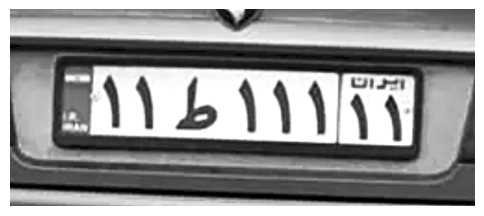

In [2]:
image_path = "pelak.png"
img = cv2.imread(image_path, 0)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(img, cmap="gray")

### Gaussian Smoothing

In [3]:
def gaussian_kernel(size, sigma=1):

    kernel = np.zeros((size, size))
    x_center = (size - 1) // 2
    y_center = (size - 1) // 2
    for i in range(size):
        for j in range(size):
            dis = -1 * ((i - x_center)**2 + (j - y_center)**2)
            kernel[i, j] = np.exp(dis/(2 * sigma* sigma))
    
    return kernel / np.sum(kernel)



def convolve(image, kernel):
    rows, cols = image.shape
    start_index = (kernel.shape[0] - 1) // 2
    output = np.zeros((rows - start_index - 1, cols - start_index - 1))
    for i in range(start_index, rows - start_index):
        for j in range(start_index, cols - start_index):
            conv = np.multiply(image[i-1: i+2, j-1: j+2], kernel)
            output[i - start_index, j - start_index] = abs(np.sum(conv))

    return output

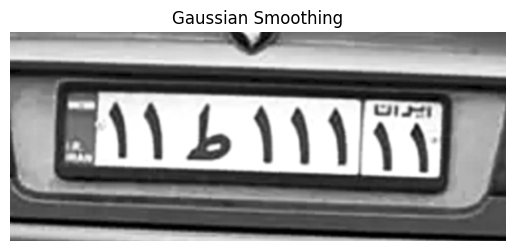

In [4]:
kernel_size = 3
sigma = 1
gaussian_filter = gaussian_kernel(kernel_size, sigma)
smoothed_img = convolve(img, gaussian_filter)
plt.imshow(smoothed_img, cmap='gray')
plt.title("Gaussian Smoothing")
plt.axis('off')
plt.show()

### Sobel

In [5]:
def sobel_gradients(image):

    horizontal = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])
    vertical = np.array([[-1, -2, -1],
                         [0, 0, 0],
                         [1, 2, 1]])

    sobel_x = convolve(image, horizontal)
    sobel_y = convolve(image, vertical)
    magnitude = np.sqrt(sobel_x * sobel_x + sobel_y * sobel_y)
    direction = np.arctan2(-1 * sobel_y, sobel_x)


    return magnitude, direction, sobel_x, sobel_y

(np.float64(-0.5), np.float64(622.5), np.float64(260.5), np.float64(-0.5))

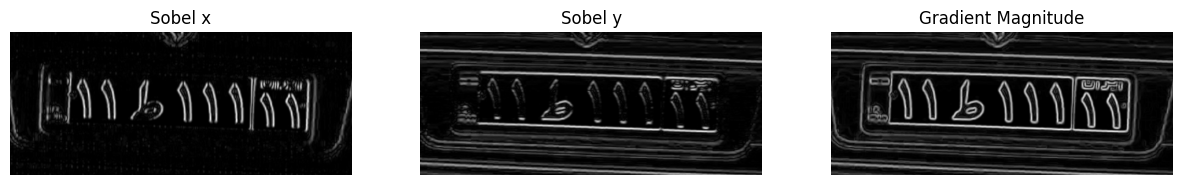

In [6]:
magnitude, direction, sobel_x, sobel_y = sobel_gradients(smoothed_img)

plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(sobel_x, cmap='gray')
plt.title("Sobel x")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(sobel_y, cmap='gray')
plt.title("Sobel y")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(magnitude, cmap='gray')
plt.title("Gradient Magnitude")
plt.axis('off')

### NMS (Non-Maximum Supression)

In [7]:
def non_maximum_suppression(magnitude, direction):

    rows, cols = magnitude.shape
    suppressed = np.zeros((rows, cols), dtype=np.float32)
    
    direction[direction < 0 ] += np.pi
    dir = [(0, 1), (-1, 1), (-1, 1), (-1, 0), (-1, 0), (-1, -1), (-1, -1), (0, -1), (0, -1)]
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            proper_dir = int((8 * direction[i, j]) // np.pi)
            delta_x, delta_y = dir[proper_dir]
            if (magnitude[i, j] >= magnitude[i+delta_x, j+delta_y]) and (magnitude[i,j] >= magnitude[i-delta_x, j-delta_y]):
                suppressed[i, j] = magnitude[i, j]
            else:
                suppressed[i, j] = 0
            
    return suppressed.astype(np.uint8)

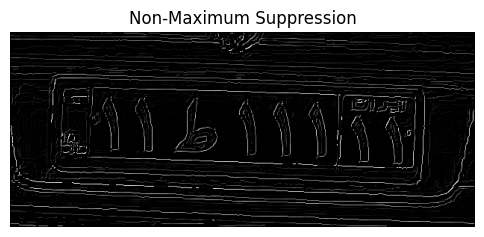

In [8]:
nms_img = non_maximum_suppression(magnitude, direction)

plt.figure(figsize=(6,6))
plt.imshow(nms_img, cmap='gray')
plt.title("Non-Maximum Suppression")
plt.axis('off')
plt.show()

### Single Thresholding (good?)

In [9]:
def simple_thresholding(image, threshold_value):

    thresholded_image = np.zeros_like(image)
    thresholded_image[image > threshold_value] = 255
    return thresholded_image

(np.float64(-0.5), np.float64(622.5), np.float64(260.5), np.float64(-0.5))

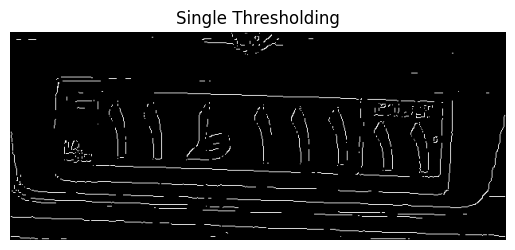

In [10]:
threshold_value = 130
thresholded_img = simple_thresholding(nms_img, threshold_value)

plt.imshow(thresholded_img, cmap='gray')
plt.title("Single Thresholding")
plt.axis('off')

### Hysteresis Thresholding (Double Thresholding)

In [11]:
def hysteresis_thresholding(image, low_threshold, high_threshold):

    edges = np.zeros_like(image)
    strong = image >= high_threshold
    weak = (image < high_threshold) & (image >= low_threshold)
    rows, cols = image.shape
    edges[strong] = 255

    check = np.zeros_like(image) # for bfs
    def bfs(v):
        queue = [v]
        check[v] = 1
        while(len(queue) != 0):
            x_v, y_v = queue.pop(0)####
            for i in range(x_v - 1, x_v + 2):
                for j in range(y_v - 1, y_v + 2):
                    if i >= 0 and i < rows and j >= 0 and j < cols:
                        if (weak[i, j]) or (not check[i, j] and strong[i, j]):
                            check[i, j] = 1
                            queue.append((i, j))#####
                            weak[i, j] = False
                            edges[i, j] = 255

    

    for i in range(0, rows):
        for j in range(0, cols):
            if strong[i, j] and not check[i, j]:
                bfs((i, j))

    return edges

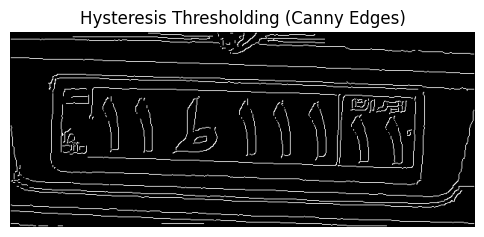

In [12]:
low_threshold = 1
high_threshold = 130
canny_edges = hysteresis_thresholding(nms_img, low_threshold, high_threshold)

plt.figure(figsize=(6,6))
plt.imshow(canny_edges, cmap='gray')
plt.title("Hysteresis Thresholding (Canny Edges)")
plt.axis('off')
plt.show()